
0: 640x480 1 flower, 41.0ms
Speed: 8.6ms preprocess, 41.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
['flower', 'pod', 'seed']


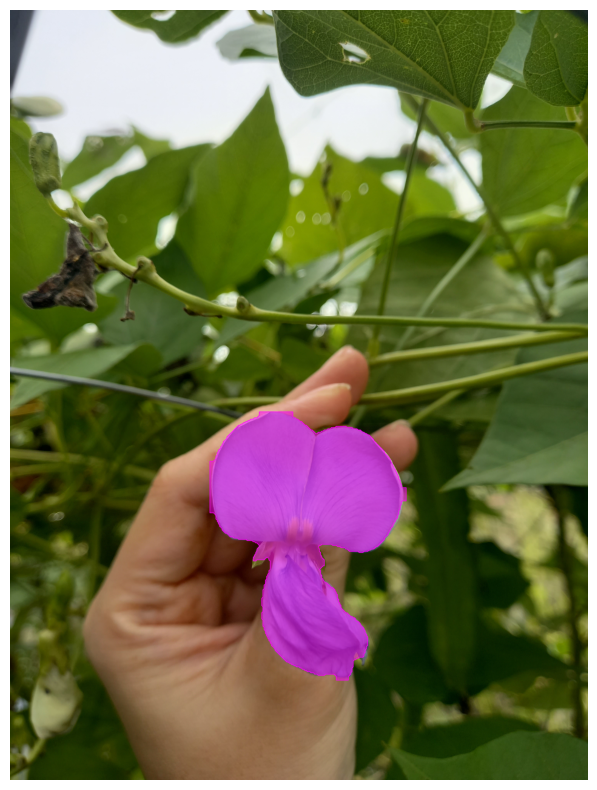

In [1]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Reading Image
img = cv2.imread("Flower141.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
model = YOLO('Yolo_segmentation.pt')

# Model prediction
results = model.predict(img)

# Get all categories
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]
print(yolo_classes)

conf = 0.6


fill_color = [255, 0, 255, 128]
line_color = [255, 0, 255, 255]  


overlay = np.zeros((img_rgb.shape[0], img_rgb.shape[1], 4), dtype=np.uint8)
overlay[..., :3] = img_rgb
overlay[..., 3] = 128  

# Processing prediction result
for result in results:
    for mask, box in zip(result.masks.xy, result.boxes):
        points = np.int32([mask])

        cv2.fillPoly(overlay, points, fill_color)

        cv2.polylines(overlay, points, isClosed=True, color=line_color, thickness=2)

# Convert the original image and overlay to PIL image in RGBA mode
img_pil = Image.fromarray(img_rgb).convert("RGBA")
overlay_pil = Image.fromarray(overlay)

# Merge the overlay with the original image
combined = Image.alpha_composite(img_pil, overlay_pil)

# Displaying image
plt.figure(figsize=(10, 10))
plt.imshow(combined)
plt.axis('off')
plt.show()



0: 640x480 1 flower, 1 pod, 58.8ms
Speed: 2.0ms preprocess, 58.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
['flower', 'pod', 'seed']


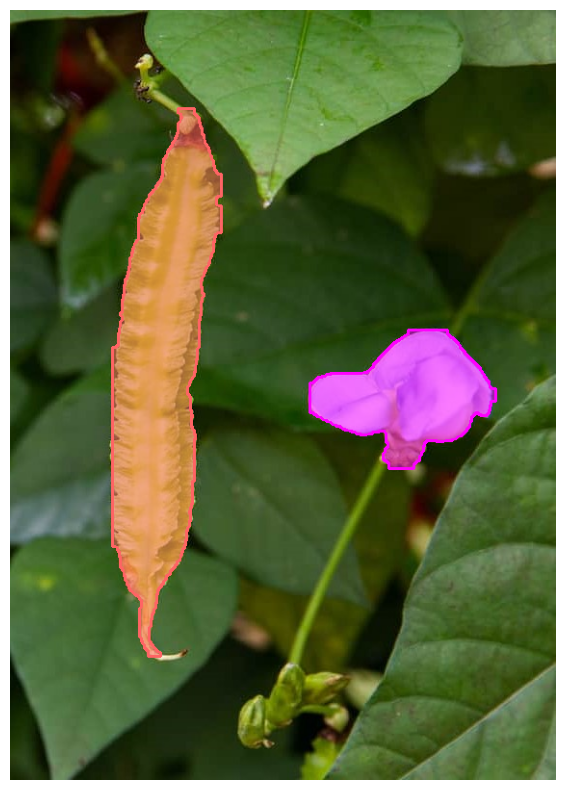

In [14]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from datetime import datetime

# Read the image
img = cv2.imread("mix.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
model = YOLO('Yolo_segmentation.pt')

# Model prediction
results = model.predict(img)

# Get all classes
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]
print(yolo_classes)

# Confidence threshold
conf = 0.6

# Define colors
colors = {
    "flower": ([255, 0, 255, 128], [255, 0, 255, 255]),  # Light purple
    "pod": ([255, 100, 100, 128], [255, 100, 100, 255]),  # Light red
    "seed": ([205, 133, 63, 128], [205, 133, 63, 255])  # Light brown
}

# Create a transparent overlay
overlay = np.zeros((img_rgb.shape[0], img_rgb.shape[1], 4), dtype=np.uint8)
overlay[..., :3] = img_rgb
overlay[..., 3] = 128  # Add alpha channel

# Create the 'sege' folder (if it doesn't exist)
output_dir = 'sege'
os.makedirs(output_dir, exist_ok=True)

# Process the prediction results
for result in results:
    for mask, box, class_id in zip(result.masks.xy, result.boxes, result.boxes.cls):
        class_id = int(class_id)
        class_name = yolo_classes[class_id]
        
        if class_name in colors:
            fill_color, line_color = colors[class_name]
        else:
            continue  # Skip classes that are not flower, pod, or seed
        
        points = np.int32([mask])
        # Fill the polygon
        cv2.fillPoly(overlay, points, fill_color)
        # Draw the polygon outline
        cv2.polylines(overlay, points, isClosed=True, color=line_color, thickness=2)
        
        # Extract the bounding box of the segmented area
        x, y, w, h = cv2.boundingRect(points)
        cropped_part = img_rgb[y:y+h, x:x+w]

        # Create an image with a transparent background
        segmented_rgba = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Copy the segmented part of the original image onto the transparent background
        for c in range(3):
            segmented_rgba[..., c] = cropped_part[..., c]

        # Create a mask for the alpha channel
        alpha_channel = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(alpha_channel, [points - [x, y]], 255)
        segmented_rgba[..., 3] = alpha_channel
        
        # Generate a unique filename
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
        part_output_path = os.path.join(output_dir, f'{class_name}_{timestamp}.png')
        Image.fromarray(segmented_rgba).save(part_output_path)

# Convert the original image and overlay to RGBA mode PIL images
img_pil = Image.fromarray(img_rgb).convert("RGBA")
overlay_pil = Image.fromarray(overlay)

# Merge the overlay with the original image
combined = Image.alpha_composite(img_pil, overlay_pil)

# Save the image to the 'sege' folder
output_path = os.path.join(output_dir, 'segmented_result.png')
combined.save(output_path)

# Display the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(combined)
plt.axis('off')
plt.show()
